# Target-embedded autoencoders

In [1]:
import typing
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
from torch import nn, optim, tensor, FloatTensor
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split
import torch.nn.functional as F

from fastai.basics import DataBunch # used for easy batching

from tea_models import LinearMLP

import matplotlib.pyplot as plt

In [40]:
torch.manual_seed(123)

In [2]:
synthetic_expression_data = pd.read_csv("data/net1_expression_data.tsv", sep='\t')
chip_features = pd.read_csv("data/net1_chip_features.tsv", sep='\t')
gene_ids = pd.read_csv("data/net1_gene_ids.tsv", sep='\t')
tfs = pd.read_csv("data/net1_transcription_factors.tsv", sep='\t')

In [3]:
X_idx = [g in tfs.iloc[:,0].tolist() for g in synthetic_expression_data.columns]

In [4]:
synthetic_expression_data.values.shape

(805, 1643)

In [5]:
train, valid, test = map(torch.FloatTensor, (
    synthetic_expression_data.values[:500, :], 
    synthetic_expression_data.values[500:700, :],
    synthetic_expression_data.values[700:, :]))

In [6]:
batch_size = 128
train_ds = TensorDataset(train[:, X_idx], train)
valid_ds = TensorDataset(valid[:, X_idx], valid)
test_ds = TensorDataset(test[:, X_idx], test)
data = DataBunch.create(train_ds, valid_ds, bs = batch_size) # easy batching

In [11]:
X, Y = next(iter(train_ds))
X.shape, Y.shape

(torch.Size([194]), torch.Size([1643]))

In [7]:
class LinearAE(nn.Module):
    """A pytorch module to build a simple linear autoencoder"""

    def __init__(self, input_dim = 194, hidden_dim = 256):
        """
        Parameters
        ----------
        input_dim : int
            The number of input (and output) features
        hidden_dim : int
            The number of features in the hidden layer
        """
        super().__init__()
        self.input = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, input_dim)
  
    def forward(self, X):
        X = self.input(X)
        return (self.output(X))

In [45]:
class LinearFEA(nn.Module):
    """A pytorch module to build a linear forward-embedding autoencoder"""

    def __init__(self, input_dim = 194, hidden_dim = 256, output_dim = 1643):
        """
        Parameters
        ----------
        input_dim : int
            The number of input features
        hidden_dim : int
            The number of features in the hidden layer
        output_dim : int
            The number of output features
        """
        super().__init__()
        self.input = nn.Linear(input_dim, hidden_dim)
        self.predict_Y = nn.Linear(hidden_dim, output_dim)
        self.reconstruct_X = nn.Linear(hidden_dim, input_dim)
  
    def forward(self, X):
        Z = self.input(X)
        Y_hat = self.predict_Y(Z)
        X_tilde = self.reconstruct_X(Z)
        return Y_hat, X_tilde

In [9]:
class joint_loss(nn.Module):
    """
    Parameters
    ----------
    lambda_ : float
        Weighting in the joint joss. 
        Higher lambda_ favours lower reconstruction loss.
    """
    def __init__(self, lambda_=0.5):
        super().__init__()
        self.X = X
        self.Y = Y
        self.lambda_ = lambda_
        
    def forward(self, X, X_tilde, Y, Y_hat):
        mse = nn.MSELoss()
        return ( ((1 - self.lambda_) * mse(Y_hat, Y)) + (self.lambda_ * mse(X_tilde, X)) )

In [12]:
lfae_loss_func = joint_loss(lambda_= .5)
mse = nn.MSELoss()
input_dim = sum(X_idx)
hidden_dim = 256
output_dim = synthetic_expression_data.shape[1]

In [46]:
lfea_model = LinearFEA(input_dim, hidden_dim, output_dim)

In [48]:
lfea_model.input.load_state_dict(lae_model.input.state_dict())

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [24]:
lae_model = LinearAE(input_dim, hidden_dim)

In [25]:
def update_lae_batch(model, X, lr, train = True):
    """update_batch takes a model, data, a learning rate and a boolean indicating whether this update 
    should be treated as a training run (i.e. the model's weights should be updated) 
    or not. This function is not for production use, as it has a number of hidden parameters (e.g. optimizer).  
    
    Parameters
    ----------
    model : torch.nn.mnodule
        The model to be updated
    X : torch.FloatTensor
        The input data (i.e feature matrix)
    lr : float
        The learning rate to be passed to the optimizer
    train : bool
        Should the weights be updated (default = True)
    """
    X_tilde = model(X)
    loss = mse(X_tilde, X)
    if train:
        opt = optim.Adam(model.parameters(), lr)
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item()

In [ ]:
def update_lfea_batch(model, X, Y, lr, train = True):
    """update_batch takes a model, data, a learning rate and a boolean indicating whether this update 
    should be treated as a training run (i.e. the model's weights should be updated) 
    or not. This function is not for production use, as it has a number of hidden parameters (e.g. optimizer).  
    
    Parameters
    ----------
    model : torch.nn.mnodule
        The model to be updated
    X : torch.FloatTensor
        The input data (i.e feature matrix)
    Y : torch.FloatTensor
        The target matrix)
    lr : float
        The learning rate to be passed to the optimizer
    train : bool
        Should the weights be updated (default = True)
    """
    Y_hat, X_tilde = model(X)
    loss = loss_func(X, X_tilde, Y, Y_hat)
    if train:
        opt = optim.Adam(model.parameters(), lr)
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item()

In [28]:
# train the linear AE
epochs = 50
lr = 1e-3
train_loss, valid_loss = [], []
for e in tqdm(range(epochs)):
    this_train_loss = np.mean([update_lae_batch(lae_model, X, lr) for X, _ in data.train_dl])
    this_valid_loss = np.mean([update_lae_batch(lae_model, X, lr, train=False) for X, _ in data.valid_dl])
    train_loss.append(this_train_loss)
    valid_loss.append(this_valid_loss)

100%|██████████| 50/50 [00:06<00:00,  7.31it/s]


In [ ]:
# # train the linear FEA
# epochs = 20
# lr = 1e-3
# train_loss, valid_loss = [], []
# for e in tqdm(range(epochs)):
#     this_train_loss = np.mean([update_lfea_batch(lfea_model, X, Y, lr) for X, Y in data.train_dl])
#     this_valid_loss = np.mean([update_lfea_batch(lfea_model, X, Y, lr, train=False) for X, Y in data.valid_dl])
#     train_loss.append(this_train_loss)
#     valid_loss.append(this_valid_loss)

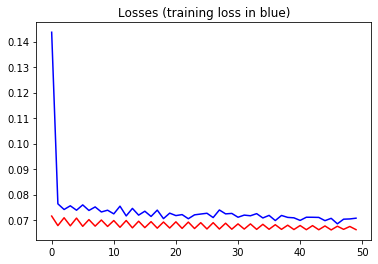

In [29]:
# plot losses
plt.plot([e for e in range(epochs)], train_loss, 'b')
plt.plot([e for e in range(epochs)], valid_loss, 'r')
plt.title("Losses (training loss in blue)")
plt.show()

### Test loss 

In [ ]:
test_pred = []
pred_error = []
mse = nn.MSELoss()
for X, Y in test_ds:
    Y_hat, _ = lfea_model(X)
    test_pred.append(Y_hat.detach().numpy())
    pred_error.append(mse(Y_hat, Y).detach().numpy())

In [ ]:
print("Final test MSE loss on prediction task: {}".format(np.mean(pred_error)))

### Visualise predicted vs. actual

In [30]:
idx = 10
X, Y = test_ds[idx]

In [49]:
Y_hat, X_tilde = lfea_model(X)
# X_tilde = lae_model(X)

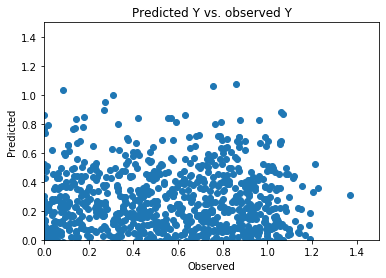

In [50]:
plt.scatter(Y.detach().numpy(), Y_hat.detach().numpy())
plt.title("Predicted Y vs. observed Y");
plt.xlim(0, 1.5)
plt.ylim(0, 1.5)
plt.xlabel("Observed");
plt.ylabel("Predicted");

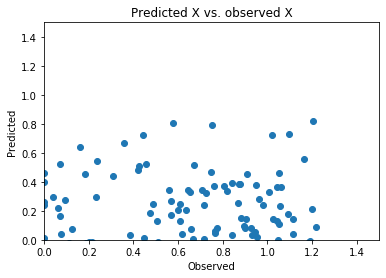

In [51]:
plt.scatter(X.detach().numpy(), X_tilde.detach().numpy())
plt.title("Predicted X vs. observed X");
plt.xlim(0, 1.5)
plt.ylim(0, 1.5)
plt.xlabel("Observed");
plt.ylabel("Predicted");

In [39]:
[p.shape for p in lae_model.parameters()]

[torch.Size([256, 194]),
 torch.Size([256]),
 torch.Size([194, 256]),
 torch.Size([194])]

In [42]:
dir(lae_model)

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backend',
 '_backward_hooks',
 '_buffers',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_get_name',
 '_load_from_state_dict',
 '_load_state_dict_pre_hooks',
 '_modules',
 '_named_members',
 '_parameters',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_slow_forward',
 '_state_dict_hooks',
 '_tracing_name',
 '_version',
 'add_module',
 'apply',
 'buffers',
 'children',
 'cpu',
 'cuda',
 'double',
 'dump_patches',
 'eval',
 'extra_repr',
 'float',
 'forward',
 'half',
 'input',
 'load_state_dict',
 'modules',
 'named_buffers',
 'named_children

In [44]:
lae_model.input.state_dict()

OrderedDict([('weight',
              tensor([[-0.0558,  0.0278,  0.0387,  ...,  0.0199, -0.0266, -0.0618],
                      [ 0.0374,  0.0049, -0.0371,  ...,  0.0165, -0.0348,  0.0179],
                      [ 0.0001,  0.0587, -0.0335,  ..., -0.0376, -0.0672,  0.0090],
                      ...,
                      [ 0.0103,  0.0242, -0.0195,  ..., -0.0120, -0.0605, -0.0407],
                      [ 0.0178, -0.0588, -0.0223,  ...,  0.0447, -0.0033,  0.0142],
                      [-0.0296, -0.0279,  0.0027,  ...,  0.0313,  0.0239, -0.0215]])),
             ('bias',
              tensor([-0.0691,  0.0194,  0.0307, -0.0213,  0.0530, -0.0522,  0.0142,  0.0674,
                       0.0539, -0.0587, -0.0630, -0.0530, -0.0168,  0.0385, -0.0700, -0.0318,
                      -0.0475, -0.0199,  0.0663, -0.0231, -0.0242,  0.0232,  0.0606, -0.0110,
                      -0.0712, -0.0260,  0.0426,  0.0473, -0.0584,  0.0257, -0.0555,  0.0743,
                       0.0048,  0.0294, -0.0